# Analyze results from running nutpie and stan on posteriordb

In [1]:
import nutpie
import pathlib
import arviz
import subprocess
import seaborn as sns
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import posteriordb
import json
import cmdstanpy
import time
import fastprogress
import pandas as pd
import xarray as xr
import holoviews as hv
import matplotlib

## Read data

In [2]:
def find_discrete(tr):
    is_discrete = ((tr.posterior == tr.posterior.round()).sum() > 100).to_array()
    if all(is_discrete):
        return []
    return list(is_discrete.where(is_discrete, np.nan).dropna("variable")["variable"].values)

In [3]:
def summarize_traces(db, storage):
    
    posterior_grad_evals_nutpie = []
    posterior_grad_evals_stan = []

    grad_evals_nutpie = []
    grad_evals_stan = []

    divs_stan = []
    divs_nutpie = []

    ess_mins_nutpie = []
    ess_mins_stan = []

    times_nutpie = []
    times_stan = []

    compile_times_nutpie = []
    compile_times_stan = []
    
    model_names = []

    ndim = []

    bfmi_stan = []
    bfmi_nutpie = []

    for i, name in enumerate(db.posterior_names()):
        try:
            tr_nutpie = arviz.from_netcdf(f"{storage}/{name}_nutpie.nc").isel(draw=slice(None, 1000))
            tr_stan = arviz.from_netcdf(f"{storage}/{name}_stan.nc").isel(draw=slice(None, 1000))
        except FileNotFoundError:
            continue
        if len(tr_nutpie.posterior.chain) != 10:
            continue
        if len(tr_stan.posterior.chain) != 10:
            continue
        
        divs_stan.append(tr_stan.sample_stats.diverging.sum())
        divs_nutpie.append(tr_nutpie.sample_stats.diverging.sum())

        posterior_grad_evals_nutpie.append(tr_nutpie.sample_stats.n_steps.sum())
        posterior_grad_evals_stan.append(tr_stan.sample_stats.n_steps.sum())
        grad_evals_nutpie.append(posterior_grad_evals_nutpie[-1] + tr_nutpie.warmup_sample_stats.n_steps.sum())
        grad_evals_stan.append(posterior_grad_evals_stan[-1] + tr_stan.warmup_sample_stats.n_steps.sum())

        times_nutpie.append(tr_nutpie.posterior.attrs["sampling_time"])
        compile_times_nutpie.append(tr_nutpie.posterior.attrs["compile_time"])
        times_stan.append(tr_stan.posterior.attrs["sampling_time"])
        compile_times_stan.append(tr_stan.posterior.attrs["compile_time"])

        ndim.append(len(tr_nutpie.sample_stats.unconstrained_parameter))

        bfmi_nutpie.append(arviz.bfmi(tr_nutpie))
        bfmi_stan.append(arviz.bfmi(tr_stan))

        discrete = find_discrete(tr_nutpie)

        ess_nutpie = xr.open_dataset(f"{storage}/{name}_nutpie_ess.nc")
        ess_stan = xr.open_dataset(f"{storage}/{name}_stan_ess.nc")
        ess_mins_nutpie.append(ess_nutpie.drop_vars(discrete).min().to_array().min().values)
        ess_mins_stan.append(ess_stan.drop_vars(discrete).min().to_array().min().values)

        model_names.append(name)

    divs_stan = np.array(divs_stan)
    divs_nutpie = np.array(divs_nutpie)
    grad_evals_nutpie = np.array(grad_evals_nutpie)
    grad_evals_stan = np.array(grad_evals_stan)
    posterior_grad_evals_nutpie = np.array(posterior_grad_evals_nutpie)
    posterior_grad_evals_stan = np.array(posterior_grad_evals_stan)
    ess_mins_nutpie = np.array(ess_mins_nutpie)
    ess_mins_stan = np.array(ess_mins_stan)
    times_nutpie = np.array(times_nutpie)
    times_stan = np.array(times_stan)
    compile_times_nutpie = np.array(compile_times_nutpie)
    compile_times_stan = np.array(compile_times_stan)
    bfmi_nutpie = np.array(bfmi_nutpie)
    bfmi_stan = np.array(bfmi_stan)
    ndim = np.array(ndim)

    ds = xr.Dataset(
        {
            "divergences": (("sampler", "model"), [divs_stan, divs_nutpie]),
            "total_grad_evals": (("sampler", "model"), [grad_evals_stan, grad_evals_nutpie]),
            "posterior_grad_evals": (("sampler", "model"), [posterior_grad_evals_stan, posterior_grad_evals_nutpie]),
            "ess": (("sampler", "model"), [ess_mins_stan, ess_mins_nutpie]),
            "time": (("sampler", "model"), [times_stan, times_nutpie]),
            "compile_time": (("sampler", "model"), [compile_times_stan, compile_times_nutpie]),
            "num_dim": (("model",), ndim),
            "bfmi": (("sampler", "model", "chain"), [bfmi_stan, bfmi_nutpie]),
        },
        coords={
            "sampler": pd.Index(["stan", "nutpie"]),
            "model": pd.Index(model_names),
        },
    )
    return ds

In [4]:
db = posteriordb.PosteriorDatabase("../../posteriordb/posterior_database/")
summaries = []
tune = [300, 400, 600, 1000]
for n_tune in tune:
    storage = f"/mnt/harddrives/data_labs/covadapt-paper/2023-08-07-model-zoo_{n_tune}/"
    summaries.append(summarize_traces(db, storage))
ds_all = xr.concat(summaries, pd.Index(tune, name="num_tune"))

/home/adr/git/arviz/arviz/utils.py:185: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


In [76]:
ds_all["ess_per_posterior_grad"] = ds_all.ess / ds_all.posterior_grad_evals
ds_all["ess_per_grad"] = ds_all.ess / ds_all.total_grad_evals
ds_all["ess_per_time"] = ds_all.ess / ds_all.time
ds_all["time_per_grad"] = ds_all.time / ds_all.total_grad_evals

In [77]:
len(ds_all.model)

132

In [78]:
# Slow models that were not skipped
list(ds_all.model[((ds_all.time.sum("num_tune") / 3600) > 0.3).sel(sampler="stan")].values)

['radon_all-radon_variable_intercept_slope_noncentered',
 'synthetic_grid_RBF_kernels-kronecker_gp']

## Diverging models

In [79]:
good = (ds_all.divergences == 0).sel(num_tune=1000)

<Axes: xlabel='sampler', ylabel='model'>

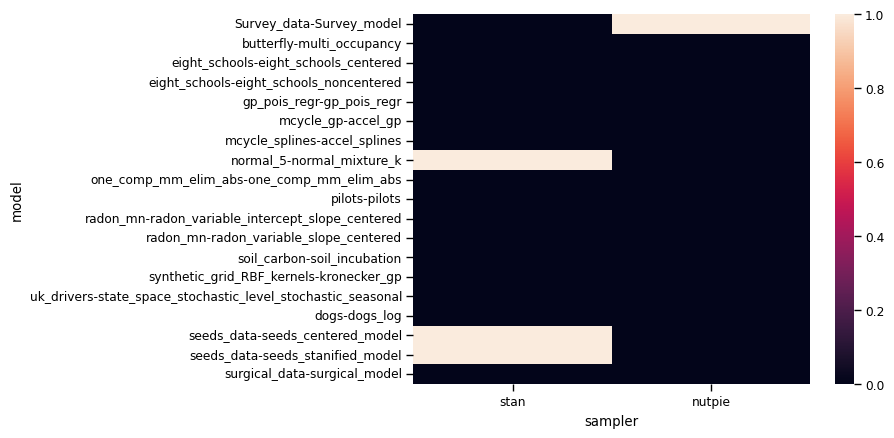

In [80]:
sns.heatmap(good.sel(model=(~good).any("sampler")).to_pandas().T)

In [81]:
good = good.any("sampler")

In [82]:
# Which models divergences for both samplers?
list(good[~good].model.values)

['butterfly-multi_occupancy',
 'eight_schools-eight_schools_centered',
 'eight_schools-eight_schools_noncentered',
 'gp_pois_regr-gp_pois_regr',
 'mcycle_gp-accel_gp',
 'mcycle_splines-accel_splines',
 'one_comp_mm_elim_abs-one_comp_mm_elim_abs',
 'pilots-pilots',
 'radon_mn-radon_variable_intercept_slope_centered',
 'radon_mn-radon_variable_slope_centered',
 'soil_carbon-soil_incubation',
 'synthetic_grid_RBF_kernels-kronecker_gp',
 'uk_drivers-state_space_stochastic_level_stochastic_seasonal',
 'dogs-dogs_log',
 'surgical_data-surgical_model']

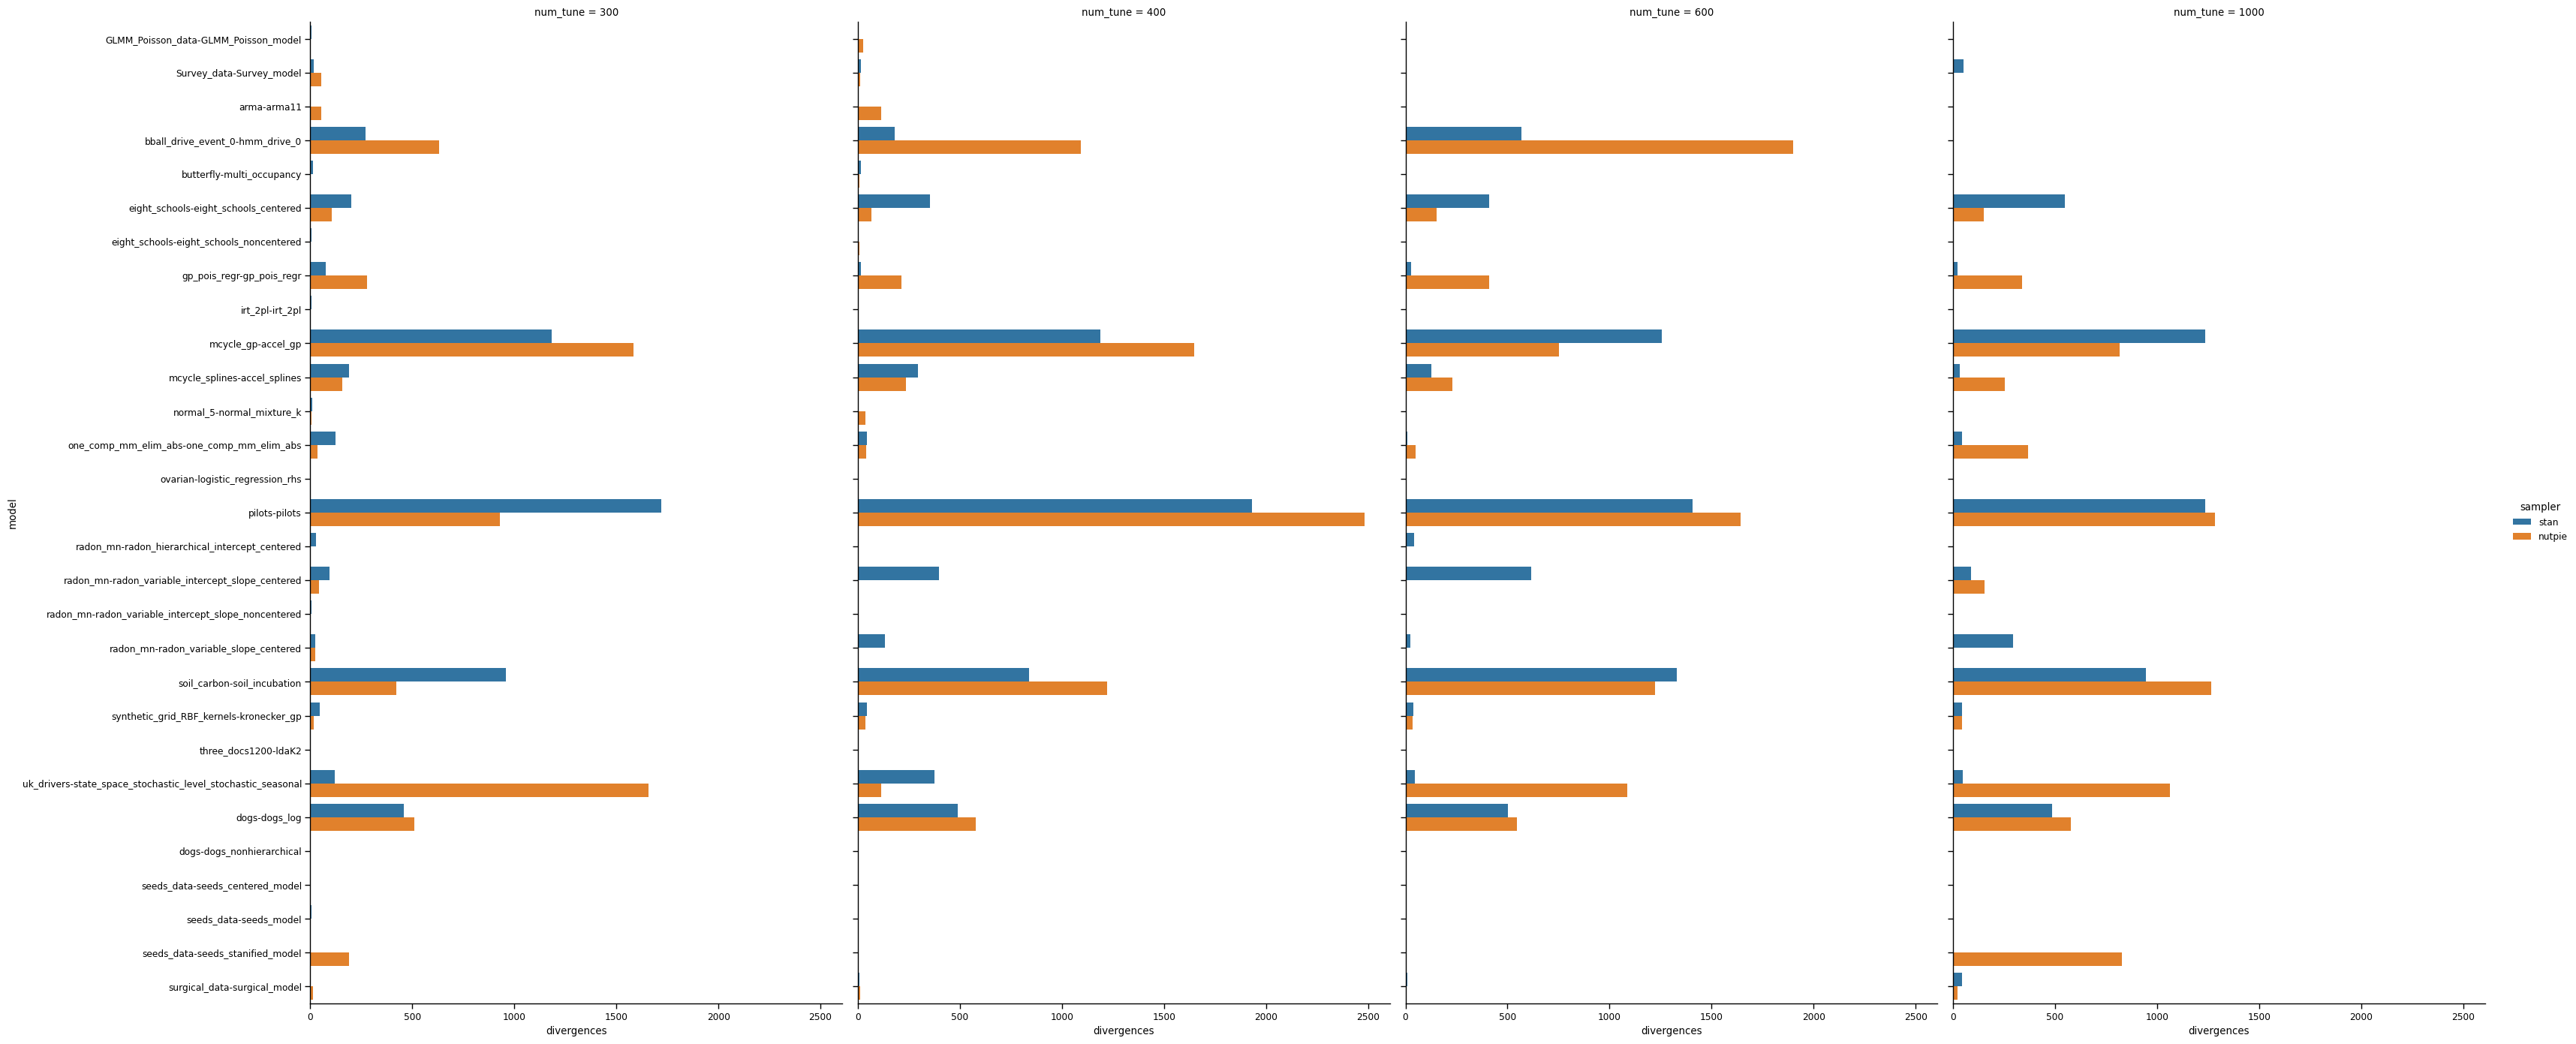

In [83]:
# Plot the number of divergences for all models that had any
ds_divs = ds_all.sel(model=ds_all.divergences.any(["sampler", "num_tune"]))
sns.catplot(ds_divs.divergences.to_dataframe().reset_index(), x="divergences", y="model", hue="sampler", col="num_tune", orient="h", kind="bar", height=14, aspect=0.6)

## Investigate remaining models

In [84]:
#ds = ds_all.sel(model=good.drop("num_tune"))
ds = ds_all
len(ds.model)

132

### Models that are unusually bad in nutpie

In [85]:
np.log2(
    ds.ess_per_time.sel(sampler="nutpie", num_tune=1000)
    / ds.ess_per_time.sel(sampler="stan", num_tune=1000)
).to_pandas().sort_values().head(10)

model
ovarian-logistic_regression_rhs                 -4.856620
seeds_data-seeds_stanified_model                -4.138525
one_comp_mm_elim_abs-one_comp_mm_elim_abs       -3.272695
soil_carbon-soil_incubation                     -1.777726
rstan_downloads-prophet                         -1.529383
gp_pois_regr-gp_pois_regr                       -1.184561
garch-garch11                                   -0.580660
state_wide_presidential_votes-hierarchical_gp   -0.437887
diamonds-diamonds                               -0.342435
arK-arK                                         -0.339598
dtype: float64

### Models that are unusually bad in stan

In [86]:
np.log2(
    ds.ess_per_time.sel(sampler="nutpie", num_tune=1000)
    / ds.ess_per_time.sel(sampler="stan", num_tune=1000)
).to_pandas().sort_values().tail(10)

model
radon_all-radon_partially_pooled_noncentered            1.855532
gp_pois_regr-gp_regr                                    1.871643
radon_all-radon_variable_intercept_noncentered          2.091125
loss_curves-losscurve_sislob                            2.236644
wells_data-wells_dist                                   2.291067
radon_all-radon_variable_slope_noncentered              2.629578
radon_all-radon_variable_intercept_slope_noncentered    3.013278
sblri-blr                                               3.351181
GLMM_Poisson_data-GLMM_Poisson_model                    3.662405
mcycle_gp-accel_gp                                      6.633426
dtype: float64

## Lots of comparison plots

In [87]:
sns.set_context("paper")

In [88]:
palette = sns.diverging_palette(220, 20, n=2 * len(ds.num_tune), s=120)

In [89]:
def plot_comparison(values):
    for i, num_tune in enumerate(values.num_tune.values):
        sns.ecdfplot(
            values.sel(num_tune=num_tune, sampler="nutpie"),
            color=palette[len(ds.num_tune) - i - 1],
            label=f"nutpie-{num_tune} warmup"
        )
    for i, num_tune in enumerate(values.num_tune.values):
        sns.ecdfplot(
            values.sel(num_tune=num_tune, sampler="stan"),
            color=palette[len(ds.num_tune) + i],
            label=f"stan-{num_tune} warmup"
        )
    plt.ylabel("Proportion of models in posteriordb")

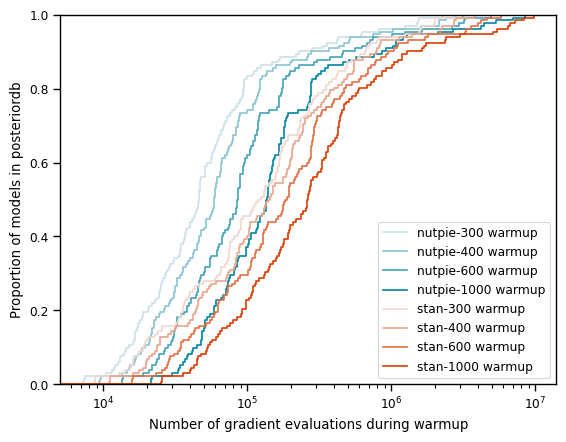

In [90]:
plot_comparison(ds.total_grad_evals - ds.posterior_grad_evals)
plt.gca().set_xscale("log", base=10)
plt.legend();
plt.xlabel("Number of gradient evaluations during warmup");

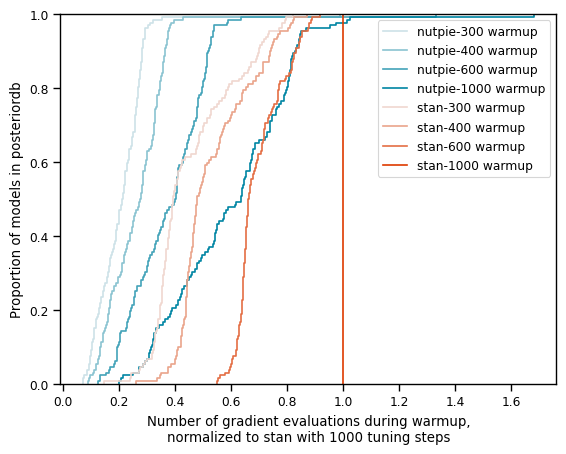

In [91]:
prior_grads = ds.total_grad_evals - ds.posterior_grad_evals
vals = prior_grads / prior_grads.sel(sampler="stan", num_tune=1000)

plot_comparison(vals)
plt.xlabel("""Number of gradient evaluations during warmup,
normalized to stan with 1000 tuning steps""")
plt.legend();

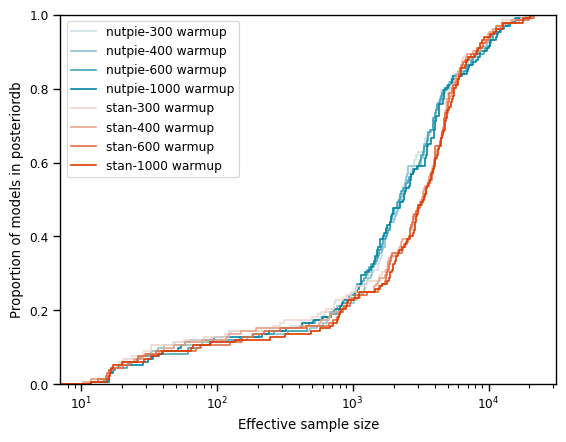

In [92]:
plot_comparison(ds.ess)
plt.gca().set_xscale("log", base=10)
plt.legend()
plt.xlabel("Effective sample size");

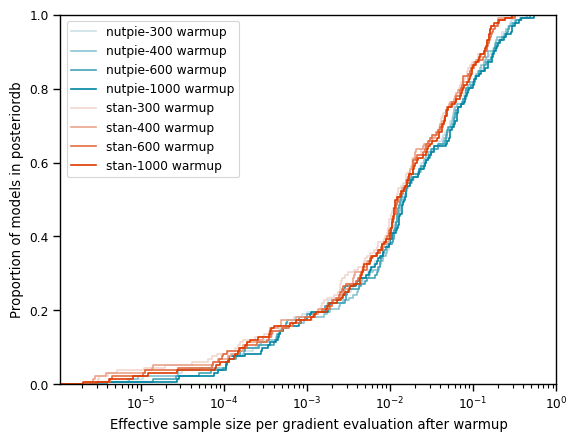

In [93]:
plot_comparison(ds.ess_per_posterior_grad)

plt.gca().set_xscale("log", base=10)
plt.legend()
plt.xlabel("Effective sample size per gradient evaluation after warmup");

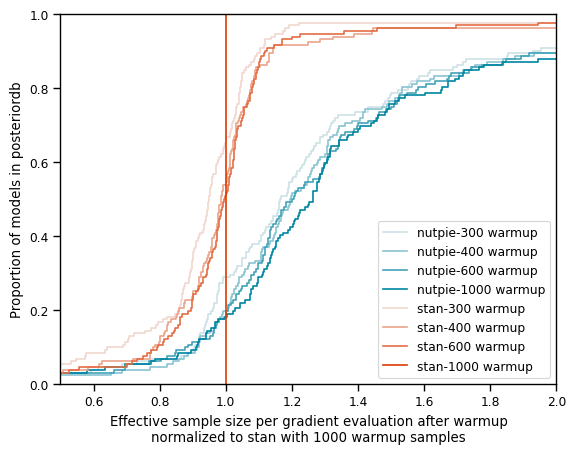

In [94]:
vals = ds.ess_per_posterior_grad
plot_comparison(vals / vals.sel(sampler="stan", num_tune=1000))

plt.xlim(0.5, 2)
plt.legend()

plt.xlabel("""Effective sample size per gradient evaluation after warmup
normalized to stan with 1000 warmup samples""");

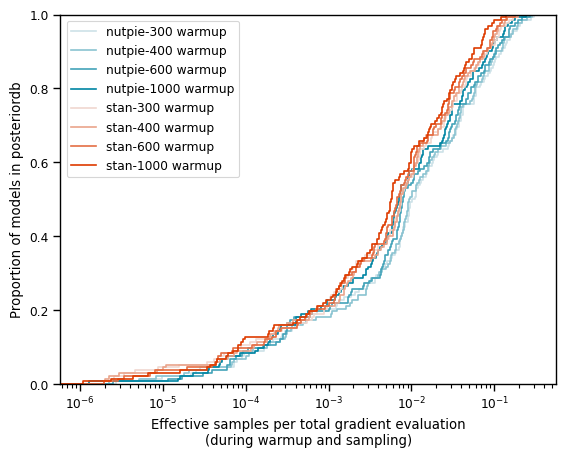

In [95]:
vals = ds.ess_per_grad
plot_comparison(vals)
plt.gca().set_xscale("log", base=10)
plt.legend()
plt.xlabel("""Effective samples per total gradient evaluation
(during warmup and sampling)""");

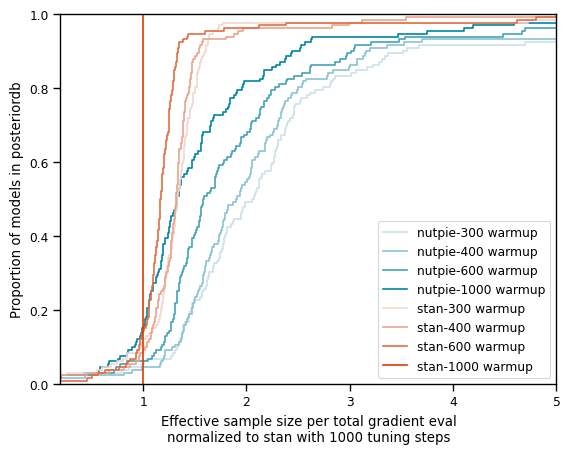

In [96]:
vals = ds.ess_per_grad
plot_comparison(vals / vals.sel(sampler="stan", num_tune=1000))
#plt.gca().set_xscale("log", base=2)
plt.xlim(0.2, 5)
plt.legend()
plt.xlabel("""Effective sample size per total gradient eval
normalized to stan with 1000 tuning steps""");

In [97]:
np.log2(ds.ess_per_grad).diff("sampler").mean("model")

<xarray.DataArray 'ess_per_grad' (num_tune: 4, sampler: 1)>
array([[0.69664113],
       [0.66865654],
       [0.5735884 ],
       [0.48969648]])
Coordinates:
  * sampler   (sampler) object 'nutpie'
  * num_tune  (num_tune) int64 300 400 600 1000

In [98]:
np.exp(
    np.log(
        ds.ess_per_grad.sel(sampler="nutpie", num_tune=400)
        / ds.ess_per_grad.sel(sampler="stan", num_tune=1000)
    ).mean("model")
)

<xarray.DataArray 'ess_per_grad' ()>
array(1.92057521)

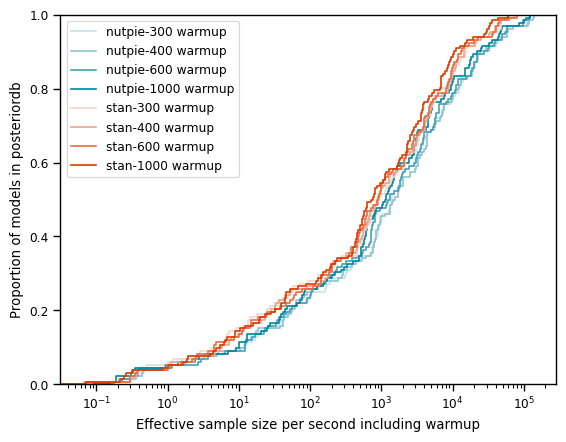

In [99]:
vals = ds.ess_per_time
plot_comparison(vals)

plt.gca().set_xscale("log", base=10)
#plt.xlim(0.2, 6)
plt.legend()
plt.xlabel("Effective sample size per second including warmup");

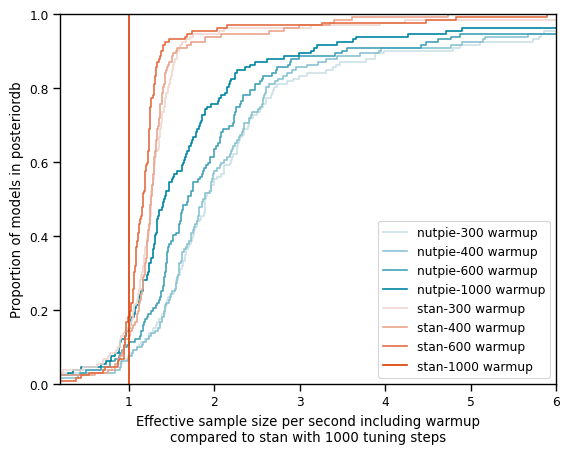

In [100]:
vals = ds.ess_per_time
plot_comparison(vals / vals.sel(sampler="stan", num_tune=1000))

plt.xlim(0.2, 6)
plt.legend()
plt.xlabel("""Effective sample size per second including warmup
compared to stan with 1000 tuning steps""");

In [108]:
np.exp(
    np.log(
        ds.ess_per_time.sel(sampler="nutpie", num_tune=400)
        / ds.ess_per_time.sel(sampler="stan", num_tune=1000)
    ).mean("model")
)

<xarray.DataArray 'ess_per_time' ()>
array(1.91684891)

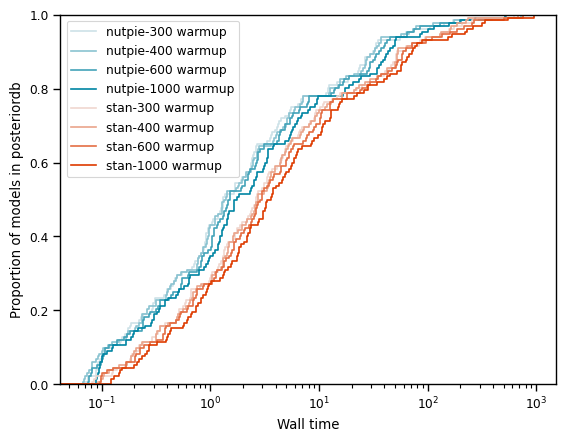

In [101]:
vals = ds.time
plot_comparison(vals)

plt.gca().set_xscale("log", base=10)
plt.legend()
plt.xlabel("Wall time");

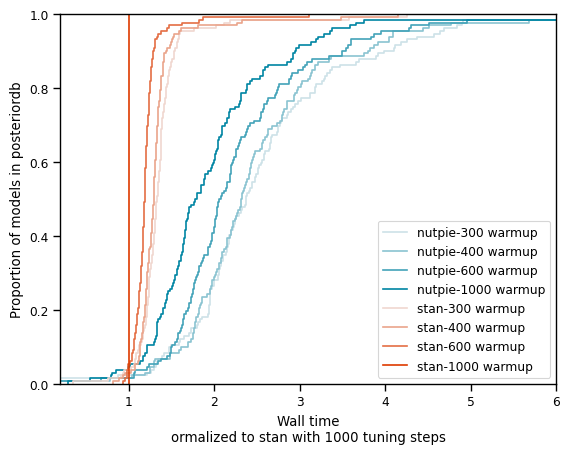

In [102]:
vals = ds.time
plot_comparison(vals.sel(sampler="stan", num_tune=1000) / vals)

plt.xlim(0.2, 6)
plt.legend()
plt.xlabel("Wall time\normalized to stan with 1000 tuning steps");

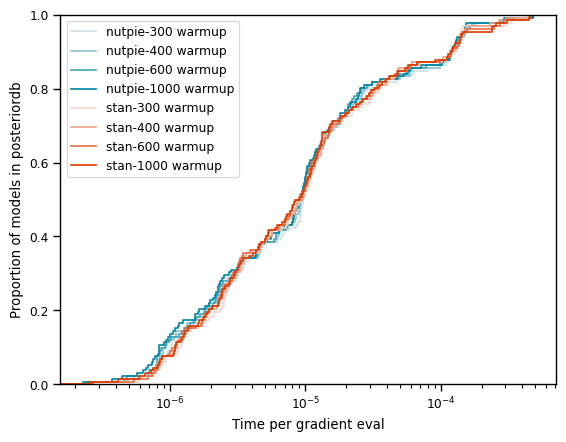

In [103]:
plot_comparison(ds.time_per_grad)
plt.gca().set_xscale("log", base=10)
plt.legend()
plt.xlabel("Time per gradient eval");

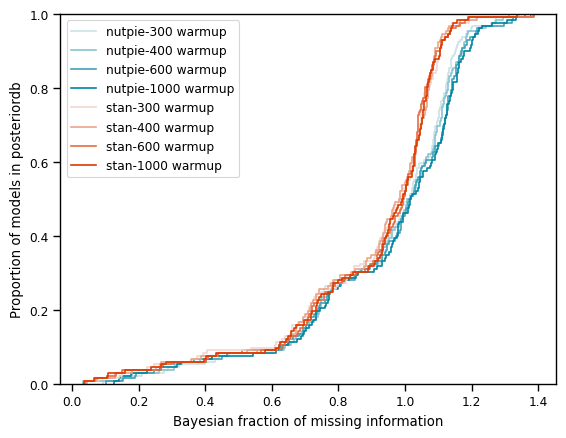

In [104]:
plot_comparison(ds.bfmi.mean("chain"))
plt.legend()
plt.xlabel("Bayesian fraction of missing information");

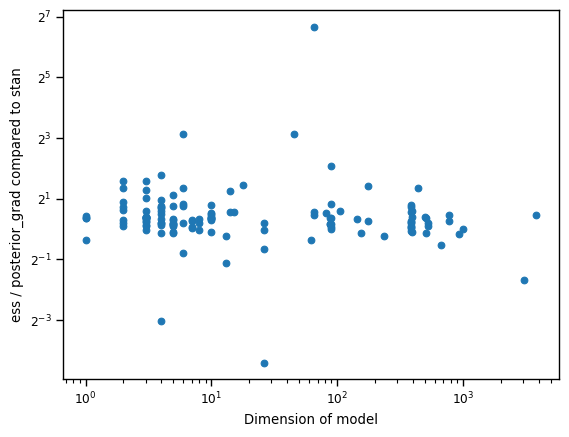

In [105]:
plt.scatter(
    ds.num_dim.isel(num_tune=0),
    (
        ds.ess_per_posterior_grad.sel(num_tune=1000, sampler="nutpie")
        / ds.ess_per_posterior_grad.sel(num_tune=1000, sampler="stan")
    )
)
plt.xlabel("Dimension of model")
plt.ylabel("ess / posterior_grad compared to stan")
plt.gca().set_xscale("log", base=10)
plt.gca().set_yscale("log", base=2);

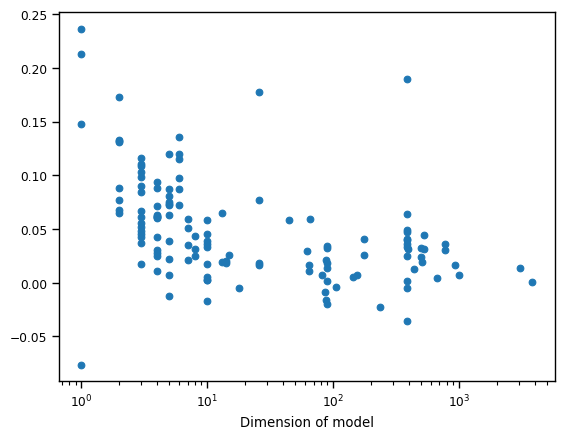

In [106]:
plt.scatter(
    ds.num_dim.isel(num_tune=0),
    ds.bfmi.mean("chain").sel(sampler="nutpie", num_tune=1000)
    - ds.bfmi.mean("chain").sel(sampler="stan", num_tune=1000)
)
plt.xlabel("Dimension of model")
plt.gca().set_xscale("log", base=10);

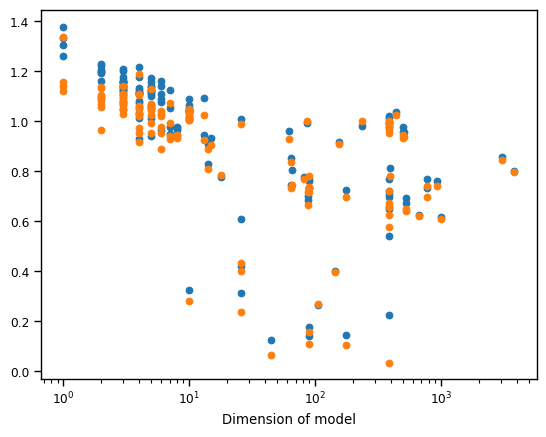

In [107]:
plt.scatter(
    ds.num_dim.isel(num_tune=0),
    ds.bfmi.mean("chain").sel(sampler="nutpie", num_tune=1000)
)
plt.scatter(
    ds.num_dim.isel(num_tune=0),
    ds.bfmi.mean("chain").sel(sampler="stan", num_tune=1000)
)
plt.xlabel("Dimension of model")
plt.gca().set_xscale("log", base=10);